In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import sys
import pandas as pd
import pickle
import re
import matplotlib.ticker as mtick
import matplotlib as mpl
import numpy as np

root_path = os.environ['FCLA_ROOT']
data_path = os.environ['DATA_PATH']
sys.path.append(os.path.join(root_path,'scripts'))

sns.set_style("whitegrid")
sns.set_context(font_scale=1.3)
# sns.set(font='sans-serif')

from mergeResults import *

In [7]:
def plot_all(dirname,expname,gurobi=False, fcla=False, log=True):
    if (gurobi):
        results15 = load_results(os.path.join(data_path, "real", dirname, "solutions", "gurobi"), 
                           os.path.join(data_path,'real',dirname))
    if (fcla):
        results15_fcla = load_results(os.path.join(data_path, "real", dirname, "solutions", "fcla"), 
                                   os.path.join(data_path,'real',dirname))
    results15_fcla_l0 = load_results(os.path.join(data_path, "real", dirname, "solutions", "fcla_l0"), 
                               os.path.join(data_path,'real',dirname))
    results15_hilbert = load_results(os.path.join(data_path, "real", dirname, "solutions", "hilbert"), 
                               os.path.join(data_path,'real',dirname))
    results15_fcla_l0 = results15_fcla_l0[results15_fcla_l0["number of facilities"] > 100]
    results15_hilbert = results15_hilbert[results15_hilbert["number of facilities"] > 100]
    
    fig, (ax1, ax2) = plt.subplots(2,figsize=(6, 6), dpi=300)
    ax1.set_yscale("log", nonposx='clip')
    if (log):
        ax1.set_xscale("log", nonposx='clip', basex=2)
    if (fcla):
        results15_fcla = results15_fcla.sort_values(by='number of facilities')
    if (gurobi):
        results15 = results15.sort_values(by='number of facilities')
    results15_fcla_l0 = results15_fcla_l0.sort_values(by='number of facilities')
    results15_hilbert = results15_hilbert.sort_values(by='number of facilities')
    if (fcla):
        ax1.plot(results15_fcla['number of facilities'],results15_fcla['runtime'], 'k.-', label="WMA BF")
    if (gurobi):
        ax1.plot(results15['number of facilities'],results15['runtime'], 'g^--', label="Gurobi")
    ax1.plot(results15_fcla_l0['number of facilities'],results15_fcla_l0['runtime'], 'ro:',label="WMA")
    ax1.plot(results15_hilbert['number of facilities'],results15_hilbert['runtime'], 'bs-',label="Hilbert")
    ax1.set_ylabel("Runtime [Sec]")
#     plt.title(expname)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=3, mode="expand", borderaxespad=0.)
    plt.setp(ax1.get_xticklabels(), visible=False)
    
#     fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
#     ax2.set_yscale("log", nonposx='clip')
    if (log):
        ax2.set_xscale("log", nonposx='clip', basex=2)
    if (fcla):
        results15_fcla = results15_fcla.sort_values(by='number of facilities')
    if (gurobi):
        results15 = results15.sort_values(by='number of facilities')
    results15_fcla_l0 = results15_fcla_l0.sort_values(by='number of facilities')
    results15_hilbert = results15_hilbert.sort_values(by='number of facilities')
    if (fcla):
        ax2.plot(results15_fcla['number of facilities'],results15_fcla['objective'], 'k.-',label="WMA BF")
    if (gurobi):
        ax2.plot(results15['number of facilities'],results15['objective'], 'g^--',label="Gurobi")
    ax2.plot(results15_fcla_l0['number of facilities'],results15_fcla_l0['objective'], 'ro:',label="WMA")
    ax2.plot(results15_hilbert['number of facilities'],results15_hilbert['objective'], 'bs-',label="Hilbert")
    ax2.set_xlabel("Number of facilities")
    ax2.set_ylabel("Objective")
    if (not log):
        ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     ax2.ticklabel_format(style='sci', axis='y')

In [50]:
expnames = [("brnn", "BRNN", sns.xkcd_rgb["amber"],'D'),
            ("hilbert", "Hilbert", sns.xkcd_rgb["denim blue"],'o'),
            ("fcla_g_rand", "WMA Naive", sns.xkcd_rgb["dusty purple"],'^'),
            ("fcla_l0", "WMA", sns.xkcd_rgb["pale red"],'s')]
typedir = "real"

def plot_all(dirname, expname, log=True, sortby="vcount",xlabel="Network size [Nodes]",lims=None,onegraph=False):
    
    sns.set_context(font_scale=0.8)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 3), dpi=300)
    
    for expname in expnames:
        results = load_results(os.path.join(data_path, typedir, dirname, "solutions", expname[0]), 
                               os.path.join(data_path,typedir,dirname)).sort_values(by=sortby)
        
        
        results = results[results['objective'].notnull()]
        runtime_results = results['runtime'].copy()
        
        if (re.match(r'gurobi',expname[0])):
            if (onegraph):
                lookfortime = -1
                for i in range(len(runtime_results)):
                    try:
                        f = open(os.path.join(data_path, typedir, dirname, results.iloc[i]['id'] + '.ntw.txt'), "r")
                        distmatxtime = float(f.read())
                        f.close()
                        lookfortime = distmatxtime
                    except IOError:
                        pass
                if (lookfortime == -1):
                    print("No gurobi found")
                else:
                    runtime_results += lookfortime
            else:
                for i in range(len(runtime_results)):
                    try:
                        f = open(os.path.join(data_path, typedir, dirname, results.iloc[i]['id'] + '.ntw.txt'), "r")
                        distmatxtime = float(f.read())
                        f.close()
                        runtime_results.loc[results.iloc[i].name] += distmatxtime
                    except IOError:
                        print("No gurobi file exists for ", expname[0])
        
        ax1.plot(results[sortby], runtime_results, expname[2], label=expname[1], marker=expname[3])
        ax2.plot(results[sortby], results['objective'], expname[2], label=expname[1], marker=expname[3])
        
    # setting first axis
    ax1.set_yscale("log")
    if (log):
        ax1.set_xscale("log", basex=10)
        ax2.set_xscale("log", basex=10)
        
    ax1.set_ylabel("Runtime [Sec]")
#     ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#               ncol=3, mode="expand", borderaxespad=0.)
    ax2.legend()
#     plt.setp(ax1.get_xticklabels(), visible=False)
    # setting second axis
#     ax2.ticklabel_format(style='sci', axis='y')
#     ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))
    ax2.set_xlabel(xlabel)
    ax1.set_xlabel(xlabel)
    ax2.set_ylabel("Objective")
    ax2.yaxis.get_major_formatter().set_powerlimits((0, 0))
    if (not log):
        ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if (lims):
        ax1.set_xlim(lims[0], lims[1])
        ax2.set_xlim(lims[0], lims[1])

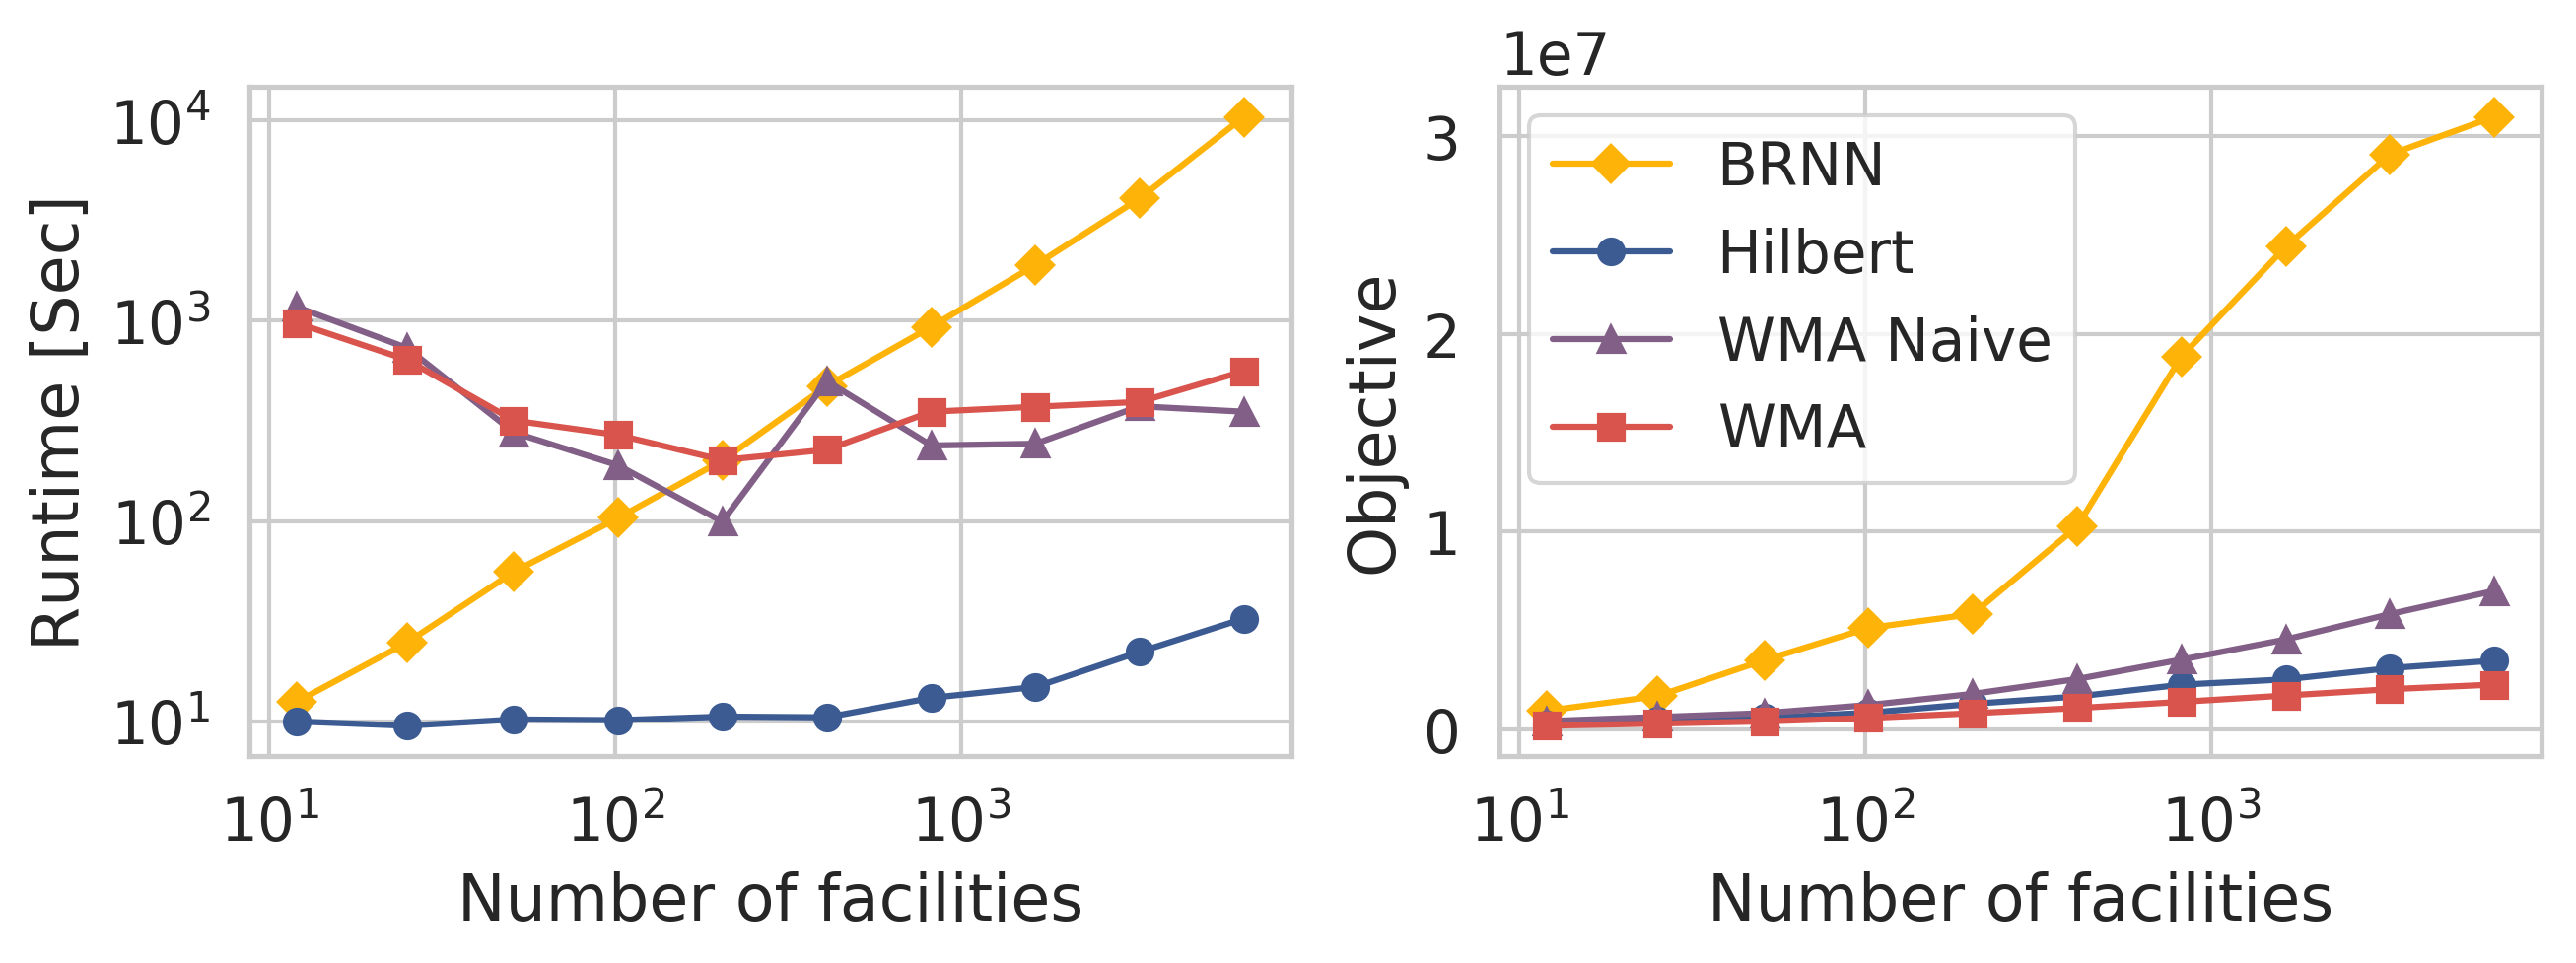

In [51]:
plot_all('pure_aalborg',"",xlabel="Number of facilities", log=True,sortby='number of facilities')

/home/alogins/.local/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


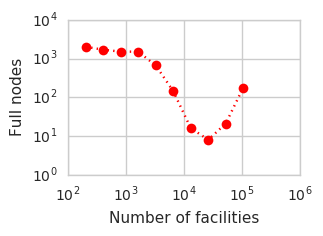

In [43]:
results15_fcla_l0 = load_results(os.path.join(data_path, "real", 'aalborg',
                                              "solutions", "fcla_l0"), 
                               os.path.join(data_path,'real','aalborg'))
fig, ax1 = plt.subplots(figsize=(3, 2), dpi=300)
ax1.set_yscale("log", nonposx='clip')
ax1.set_xscale("log", nonposx='clip')
sortby="number of facilities"
results15_fcla_l0 = results15_fcla_l0.sort_values(by=sortby)
ax1.plot(results15_fcla_l0[sortby],results15_fcla_l0['fullfac'], 'ro:',label="WMA")

ax1.set_ylabel("Full nodes")
ax1.set_xlabel("Number of facilities")

/home/alogins/.local/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


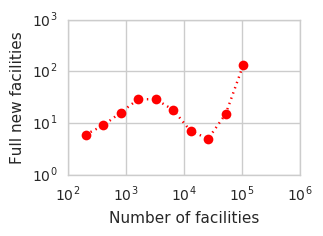

In [44]:
results15_fcla_l0 = load_results(os.path.join(data_path, "real", 'aalborg',
                                              "solutions", "fcla_l0"), 
                               os.path.join(data_path,'real','aalborg'))
fig, ax1 = plt.subplots(figsize=(3, 2), dpi=300)
ax1.set_yscale("log", nonposx='clip')
ax1.set_xscale("log", nonposx='clip')
sortby="number of facilities"
results15_fcla_l0 = results15_fcla_l0.sort_values(by=sortby)
ax1.plot(results15_fcla_l0[sortby],results15_fcla_l0['full facilities'], 'ro:',label="WMA")
ax1.set_ylabel("Full new facilities")
ax1.set_xlabel("Number of facilities")

/home/alogins/.local/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


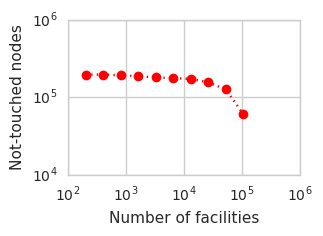

In [45]:
results15_fcla_l0 = load_results(os.path.join(data_path, "real", 'aalborg',
                                              "solutions", "fcla_l0"), 
                               os.path.join(data_path,'real','aalborg'))
fig, ax1 = plt.subplots(figsize=(3, 2), dpi=300)
ax1.set_yscale("log", nonposx='clip')
ax1.set_xscale("log", nonposx='clip')
sortby="number of facilities"
results15_fcla_l0 = results15_fcla_l0.sort_values(by=sortby)
ax1.plot(results15_fcla_l0[sortby],results15_fcla_l0['nullfac'], 'ro:',label="WMA")
ax1.set_ylabel("Not-touched nodes")
ax1.set_xlabel("Number of facilities")

/home/alogins/.local/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


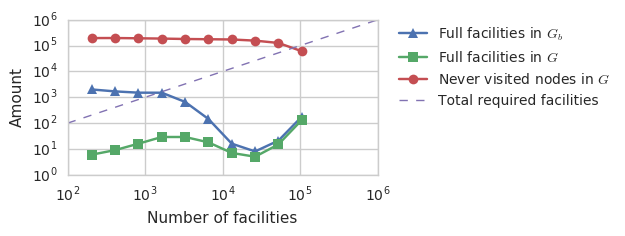

In [76]:
results15_fcla_l0 = load_results(os.path.join(data_path, "real", 'aalborg',
                                              "solutions", "fcla_l0"), 
                               os.path.join(data_path,'real','aalborg'))
fig, ax1 = plt.subplots(figsize=(4, 2), dpi=300)
ax1.set_yscale("log", nonposx='clip')
ax1.set_xscale("log", nonposx='clip')
sortby="number of facilities"
results15_fcla_l0 = results15_fcla_l0.sort_values(by=sortby)
ax1.plot(results15_fcla_l0[sortby],results15_fcla_l0['fullfac'], '^-',label="Full facilities in $G_b$")
ax1.plot(results15_fcla_l0[sortby],results15_fcla_l0['full facilities'], 's-',label="Full facilities in $G$")
ax1.plot(results15_fcla_l0[sortby],results15_fcla_l0['nullfac'], 'o-',label="Never visited nodes in $G$")
ax1.plot([10**2, 10**6], [10**2, 10**6], '--', linewidth=1, label="Total required facilities")
ax1.set_ylabel("Amount")
ax1.set_xlabel("Number of facilities")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [37]:
results_lvegas = load_results(os.path.join(data_path, "real", 'lvegas',
                                              "solutions", "fcla_l0"), 
                                 os.path.join(data_path,'real','lvegas'))

In [5]:
results_lvegas.columns

Index(['Created', 'bipartite graph size', 'capacity of facilities',
       'facilities left after termination', 'facilities_indexes',
       'fcla initialization', 'full facilities', 'greedy deheap iterations',
       'id', 'lambda', 'left count', 'matching', 'matching count',
       'number of facilities', 'number of iterations', 'objective',
       'reading file', 'relative gain', 'result final calculation time',
       'runtime', 'set cover check time', 'total covered final', 'total time',
       'uniform capacities', 'avg_clustering', 'avg_degree', 'avg_dist',
       'ecount', 'max_degree', 'max_dist', 'min_degree', 'min_dist',
       'source_avg_clust', 'source_num', 'std_degree', 'std_dist', 'vcount'],
      dtype='object')

In [6]:
results_lvegas.loc[6]

Created                                                       Mon Jun 25 12:29:57 2018
bipartite graph size                                                              5090
capacity of facilities                                                               0
facilities left after termination                                                    0
facilities_indexes                   129080,45692,23392,138724,214938,31923,106773,...
fcla initialization                                                            21.3301
full facilities                                                                      8
greedy deheap iterations             [60, 62, 65, 65, 69, 74, 79, 87, 79, 81, 69, 6...
id                                                                                 111
lambda                                                                               0
left count                           [1000, 964, 929, 896, 866, 842, 821, 800, 782,...
matching                             [3.819

In [38]:
expdata = results_lvegas.loc[6]

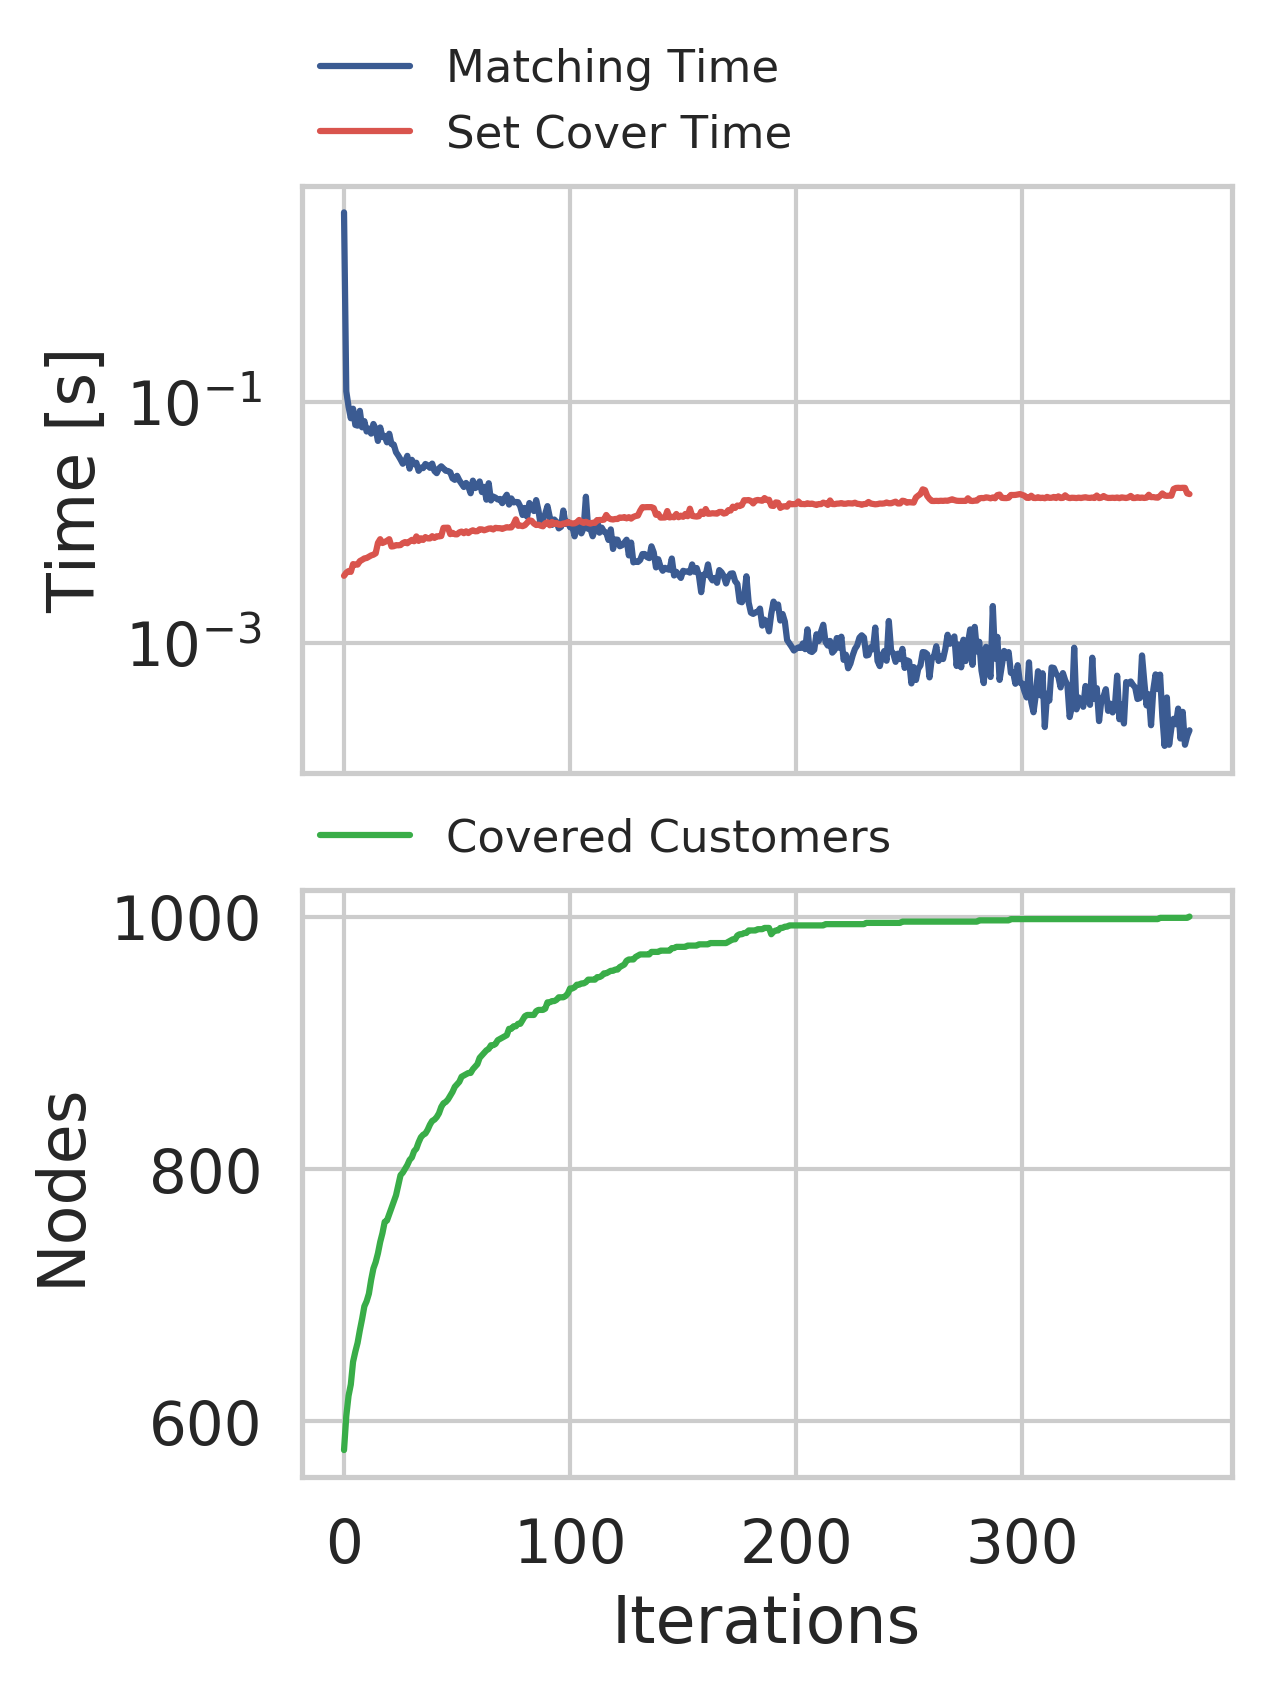

In [39]:
# sns.set_context("paper")
fontscale = 1.3
sns.set(font_scale=fontscale,style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2,figsize=(4, 5.7), dpi=300)


ax2.plot(expdata['total covered final'],color=sns.xkcd_rgb["medium green"],label="Covered Customers")
ax1.semilogy(expdata['matching'],color=sns.xkcd_rgb["denim blue"],label="Matching Time")
ax1.semilogy(expdata['set cover check time'],color=sns.xkcd_rgb["pale red"],label="Set Cover Time")

ax2.set_ylabel("Nodes")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel("Time [s]")
ax2.set_xlabel("Iterations")
# ax1.legend(mode="expand", borderaxespad=0., loc="lower right" )
# ax2.legend(mode="expand", borderaxespad=0., loc="lower right" )
# ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=1, mode="expand", borderaxespad=0.,frameon=False, fontsize='x-small')
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=1, mode="expand", borderaxespad=0.,frameon=False, fontsize='x-small')
# sns.set_context(font_scale=0.6)
# setting second axis
#     ax2.ticklabel_format(style='sci', axis='y')
#     ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True, useOffset=False))